In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1, CNN_1D

In [96]:
# # generate some training data
n_samples = 220
seq_len = 18

## generate sin wave data with different frequencies
def generate_sin_wave_data(n_samples, seq_len, noise=0.1, seed=42):
    np.random.seed(seed)
    X = []
    y = []
    for i in range(n_samples):
        freq = np.random.uniform(0.1, 1.0)  # frequency between 0.1 and 1.0
        x = np.linspace(0, 6 * np.pi, seq_len)
        seq = np.sin(freq * x) + np.random.normal(0, noise, seq_len)  # add some noise
        X.append(seq)
        y.append(freq)  # target is the frequency
    X = np.array(X).reshape(n_samples, seq_len, 1)  # shape (n_samples, seq_len, 1)
    y = np.array(y).reshape(n_samples, 1)  # shape (n_samples, 1)
    return X, y

X, y_true = generate_sin_wave_data(n_samples, seq_len, noise=0.05)
# normalize X to [0, 1]
X = (X - X.min()) / (X.max() - X.min())
print(f"Generated data shapes: {X.shape}, {y_true.shape}")

Generated data shapes: (220, 18, 1), (220, 1)


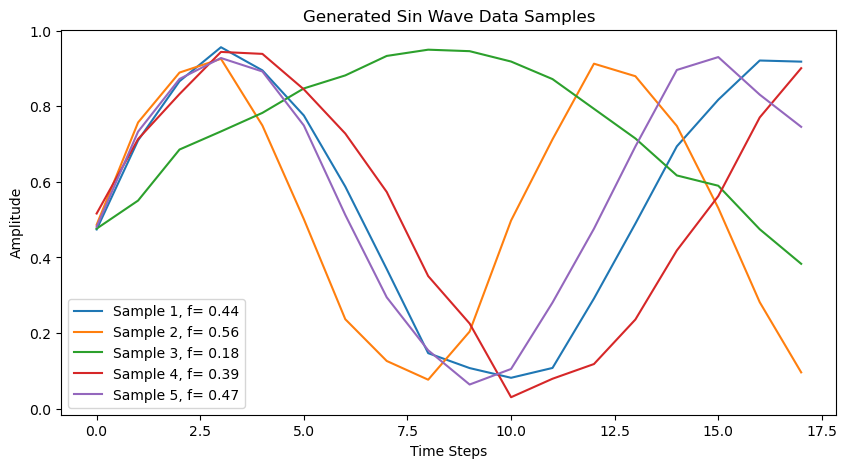

In [97]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X[i].flatten(), label=f"Sample {i+1}, f= {y_true[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [108]:
# train test split
percentage = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, test_size=1 - percentage, random_state=42
)

In [114]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 5),  # =1D kernel size
    "input_length": seq_len,
    "stride": 1,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
}

CNN_classical = CNN_1D(hparams=hparams)

In [115]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
CNN_classical.train()
optimizer = torch.optim.Adam(
    CNN_classical.parameters(), lr=0.01, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical.parameters()]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float32)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float32
        ).squeeze(1)
        batch_out = CNN_classical(x_batch.transpose(1, 2))  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted.squeeze(1), y_batch)
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append([copy.deepcopy(p) for p in CNN_classical.parameters()])
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 train loss: 0.05537479624829509


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 train loss: 0.02003293133086779


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 train loss: 0.012144048952243545


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 train loss: 0.011108438272706488


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 train loss: 0.012760768136517569


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 train loss: 0.011022895066575571


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 train loss: 0.009388216474855488


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 train loss: 0.013221450531008568


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 train loss: 0.009005301356823607


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 train loss: 0.009821504989469593


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 train loss: 0.010785033799369226


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 train loss: 0.009589543058113619


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 train loss: 0.007551358737559481


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 train loss: 0.007296503563834863


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 train loss: 0.006899939003315839


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 train loss: 0.008926988706331362


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 train loss: 0.007604142227633433


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 train loss: 0.008685609325766563


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 train loss: 0.005647577239539136


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 train loss: 0.008846400982954285


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 train loss: 0.0065544778057797385


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 train loss: 0.009641798594119873


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 train loss: 0.007827127606353977


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 train loss: 0.005568309390748089


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 train loss: 0.006748465884646232


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 train loss: 0.008667294549840417


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 train loss: 0.005186903438615528


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 train loss: 0.006455315679142421


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 train loss: 0.006864665266634388


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 train loss: 0.004784735088998621


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 train loss: 0.006548762223577465


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32 train loss: 0.005852203922007571


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33 train loss: 0.007062726124951785


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34 train loss: 0.007500171026384289


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 train loss: 0.008135175459425558


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36 train loss: 0.005330589345910333


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37 train loss: 0.007690468104556203


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38 train loss: 0.00588080894455991


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 train loss: 0.007558882511644201


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 train loss: 0.005779330756261267


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41 train loss: 0.007229042451151393


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 42 train loss: 0.007264805386181582


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43 train loss: 0.008512076053937728


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44 train loss: 0.006906537995250387


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 45 train loss: 0.005627081708305262


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 46 train loss: 0.007037109822373499


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47 train loss: 0.006742133970626376


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48 train loss: 0.006647798973558979


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 49 train loss: 0.005954925457692959


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 50 train loss: 0.006910955194722523
Final loss (MSE): 0.0015920507721602917
Final loss (RMSE): 0.03990051092605572


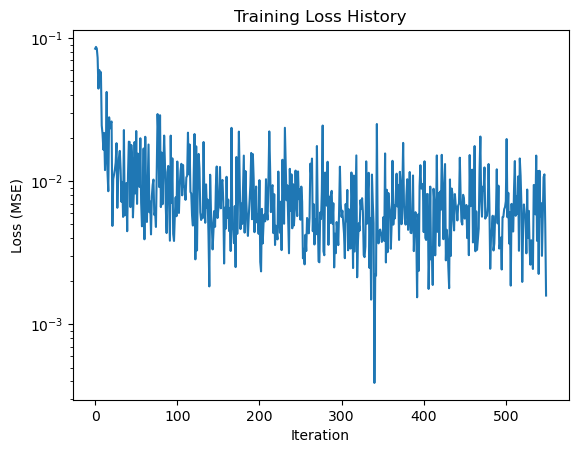

In [116]:
plt.plot(loss_hist)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.show()

In [121]:
# test the model
CNN_classical.eval()
y_pred_test = []
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float32)
    y_test_tmp = torch.tensor(y_test, dtype=torch.float32).squeeze(1)
    predicted = CNN_classical(x_test.transpose(1, 2)).squeeze(1)  # (batch_size, 1, seq_len)
    y_pred_test.append(predicted.numpy())
    test_loss = loss_fn(predicted, y_test_tmp)
    print(f"Test loss (MSE): {test_loss.item()}")
    print(f"Test loss (RMSE): {np.sqrt(test_loss.item())}")
y_pred_test = np.concatenate(y_pred_test, axis=0)

Test loss (MSE): 0.002481345785781741
Test loss (RMSE): 0.04981310857376541


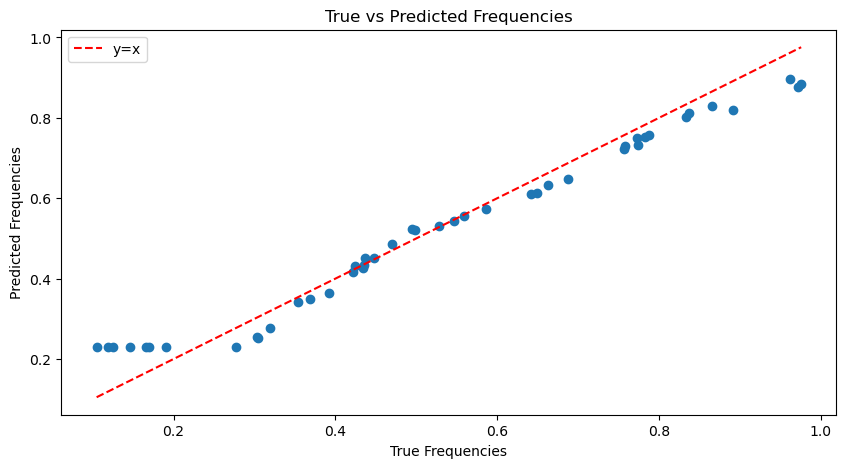

In [129]:
# plot the results
plt.figure(figsize=(10, 5))
plt.scatter(y_test_tmp, predicted.numpy())
# diagonal line
plt.plot([y_test_tmp.min(), y_test_tmp.max()], [y_test_tmp.min(), y_test_tmp.max()], 'r--', label='y=x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("True Frequencies")
plt.ylabel("Predicted Frequencies")
plt.legend()
plt.show()

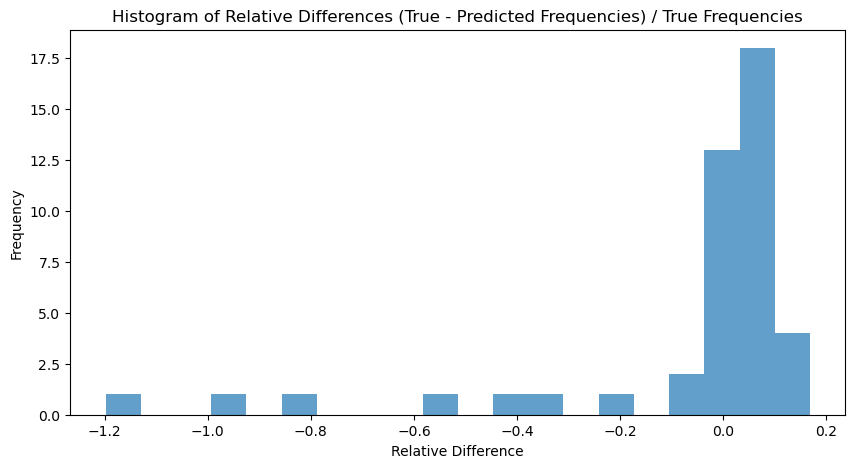

In [139]:
diffs = y_test.squeeze(1) - y_pred_test
rel_diffs = diffs / y_test.squeeze(1)  # relative differences
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(rel_diffs, bins=20, alpha=0.7)
plt.title("Histogram of Relative Differences (True - Predicted Frequencies) / True Frequencies")
plt.xlabel("Relative Difference")
plt.ylabel("Frequency")
plt.show()